# CNN-Model for Image Classificaiton (CIFAR-10)

The following notebook shows the process of building and training a CNN model for image-classification using tensorflow and keras. 

I will use the well known [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which consists of 60000 32x32 RGB images from ten different classes (vehicles as well as animals): 
- airplane,
- automobile,
- bird,
- cat,
- deer,
- dog,
- frog,
- horse, 
- ship,
- truck.

The model we are going to build will have a (comparably) simple architecture with (only) 420,842 parameters in total, still reaching an accuracy on the test set of over 89%.

## 1. Import Dependencies and load Data

In [299]:
%reload_ext autoreload
%autoreload 2

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import PlotModelEval, PlotConfusionMatrix, PlotRandomFromEachClass

# Deep learning
import tensorflow as tf
import tensorflow.keras as keras

# Data and preprocessing
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D

# Regularizaiton
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Weights and Biases training tracking
import wandb
from wandb.keras import WandbCallback

In [67]:
# Check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [318]:
# Load data and store labels
num_classes = 10
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In the following we will plot three random example pictures from each of the ten categories:

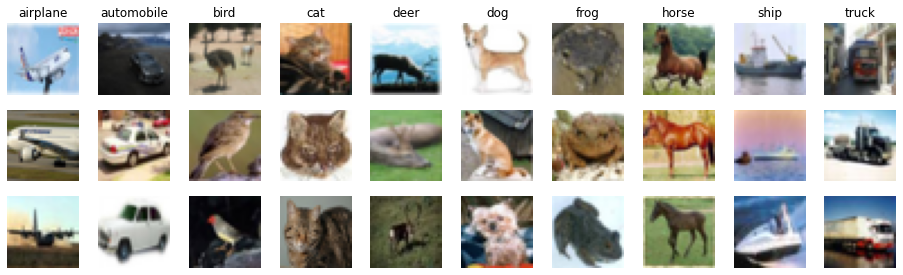

In [316]:
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)
# plt.savefig("./img/all_classes", bbox_inches='tight', facecolor="white", dpi=150)

## 2. Preprocessing and Model building

In [319]:
# Transform label indices to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### ImageGenerator
<br>
To reduce overfitting of the model, we will not only use EarlyStopping and Dropout, but we will also use an ImageGenerator, which adds random transformations (within borders you specify yourself) to the image. So our model will not be trained on the pure images themselves, but instead we will train an ImageGenerator, which will transform the Training-Batches before feeding them to the network.

In this way, the network will overfit less and generalize better since it never sees the same picture twice but always a slightly different version of it (e.g. rotated/flipped horizontally/...). 

The following code shows an ImageGenerator in action, which will rotate pictures up to 90 degrees, zoom in and out and flips the image horizontally (everything chosen random on the fly of course). You can clearly see the different transformations on the example pictures:

In [72]:
# Calling ImageGenerator 
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Specify the flow, the original data and the batch size
flow = datagen.flow(X_train, y_train, batch_size=9) 

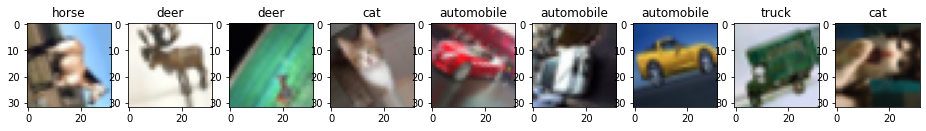

In [73]:
# Get one batch 
rnd_img_batch = flow.next()

plt.figure(figsize=(16, 64))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image, label = rnd_img_batch[0][i], rnd_img_batch[1][i]
    plt.imshow(image)
    plt.title(cifar_labels[np.argmax(label)])

**Split training set into training and validation set**
<br>
Since the data is already shuffled, it is okay to simply take the first 10000 sample images as the validation set and the rest as the training set.

In [74]:
idx = round(0.2*X_train.shape[0])
X_val, X_train = X_train[:idx, ], X_train[idx:, ]
y_val, y_train = y_train[:idx, ], y_train[idx:, ]

In [75]:
print(f'Size of training-set  : {X_val.shape}')
print(f'Size of validation-set: {X_val.shape}')

(10000, 32, 32, 3)

### Weights and Biases setup

In [76]:
# Login to wandb
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [77]:
# Iterator for model run count
i=40

In [81]:
# Initialize run with hyperparameters 
batch_size = 64
epochs = 200
learning_rate = 0.0025 


wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="CIFAR10-Classification", 
           entity="patricksvm",
           config=wandb.config,
           name = f"CIFAR-Run-{i}")

i+=1

accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▆▇▆▇▇▇▇▇▇██▇████▇████▇██████████████
val_loss,█▅▅▃▃▂▃▂▂▂▂▂▁▁▁▂▁▁▂▁▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁
accuracy,0.92323
best_epoch,144
best_val_loss,0.32411
epoch,179
loss,0.21515
val_accuracy,0.8951


### Build and train the model

We will train a model on an ImageGenerator with horizontal flip, slight height and width shift and rotantion range of 17 degrees. In each layer we will use ELU-activation, Kernel-size of 3x3 and Same-padding and apply BatchNorm directly after each Convolution and before feeding the results to the Activation. The structure of the model will be as follows:

**Block1**
- two Conv2D-layers with 32 filters
- MaxPooling2D with (2,2) and Stride=2 (so reduces feature map dimensions by 50%)
- 20%-Dropout 

**Block 2**
- two Conv2D-layers with 64 filters
- MaxPooling2D with (2,2) and Stride=2 
- 20%-Dropout 

**Block 3**
- two Conv2D-layers with 128 filters
- MaxPooling2D with (2,2) and Stride=2 
- 30%-Dropout 

**Block 4**
- Flatten input
- Dense-Layer with 64 hidden units
- 30%-Dropout 
- Softmax activation with 10 units, one for each class 

The ImageGenerator that will be utilized as Training-input will randomly rotate images up to 17 degrees, has width_shift_range/height_shift_range of 0.08 and can also flip images horizontally.

In addition to the Dropout-regularization, EarlyStopping with patience of 35 (total epochs specified: 200) with respect to validation accuracy is also used. 

As optimizer, Nadam with a learning rate of 0.0025 showed good results with a batch size of 64.

In [82]:
def build_model(input_shape=X_train.shape[1:], num_classes=num_classes):
    """
    Function that builds our custom model and returns it.
    
    """
    # Set up Sequential model
    model = Sequential()
    
    # First block, 2x Conv2D(32 filters) and MaxPooling
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Second block, 2x Conv2D(64 filters) and MaxPooling 
    model.add(Conv2D(64, (3,3), padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Third block, 2x Conv2D(128 filters) and MaxPooling
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully connected part with 64 hidden neurons
    model.add(Flatten())
    model.add(Dense(64, activation=None))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    
    return model

In [83]:
model = build_model()

# Setup ImageGenerator with best hyperparameters
datagen = ImageDataGenerator(rotation_range=17, 
                             width_shift_range=0.08, 
                             height_shift_range=0.08, 
                             horizontal_flip=True)

# Setup flow
flow_train = datagen.flow(X_train, y_train, batch_size=batch_size)

# Specify early stopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=35, verbose=1, restore_best_weights=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), metrics=['accuracy'])

# Train model
hist = model.fit(flow_train,
                 steps_per_epoch=(X_train.shape[0]) // batch_size,
                 epochs=epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[WandbCallback(), early_stop],
                 verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_49 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_50 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_43 (Activation)  (None, 32, 32, 32)       

2022-08-16 10:50:27.844141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.4684 - accuracy: 0.4714

2022-08-16 10:51:20.344032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 61s 90ms/step - loss: 1.4684 - accuracy: 0.4714 - val_loss: 1.4509 - val_accuracy: 0.5288 - _timestamp: 1660639886.0000 - _runtime: 242.0000
Epoch 2/200
625/625 [==============================] - 54s 87ms/step - loss: 1.0885 - accuracy: 0.6149 - val_loss: 1.1680 - val_accuracy: 0.6120 - _timestamp: 1660639941.0000 - _runtime: 297.0000
Epoch 3/200
625/625 [==============================] - 56s 89ms/step - loss: 0.9626 - accuracy: 0.6626 - val_loss: 1.1042 - val_accuracy: 0.6223 - _timestamp: 1660639997.0000 - _runtime: 353.0000
Epoch 4/200
625/625 [==============================] - 53s 85ms/step - loss: 0.8881 - accuracy: 0.6887 - val_loss: 0.8956 - val_accuracy: 0.7013 - _timestamp: 1660640050.0000 - _runtime: 406.0000
Epoch 5/200
625/625 [==============================] - 53s 84ms/step - loss: 0.8323 - accuracy: 0.7082 - val_loss: 0.7791 - val_accuracy: 0.7335 - _timestamp: 1660640102.0000 - _runtime: 458.0000
Epoch 6/200
625/625 [===========

Epoch 43/200
625/625 [==============================] - 54s 86ms/step - loss: 0.3862 - accuracy: 0.8653 - val_loss: 0.4437 - val_accuracy: 0.8578 - _timestamp: 1660642108.0000 - _runtime: 2464.0000
Epoch 44/200
625/625 [==============================] - 52s 84ms/step - loss: 0.3802 - accuracy: 0.8693 - val_loss: 0.4534 - val_accuracy: 0.8508 - _timestamp: 1660642160.0000 - _runtime: 2516.0000
Epoch 45/200
625/625 [==============================] - 52s 83ms/step - loss: 0.3747 - accuracy: 0.8692 - val_loss: 0.3884 - val_accuracy: 0.8706 - _timestamp: 1660642213.0000 - _runtime: 2569.0000
Epoch 46/200
625/625 [==============================] - 52s 84ms/step - loss: 0.3696 - accuracy: 0.8716 - val_loss: 0.4101 - val_accuracy: 0.8614 - _timestamp: 1660642265.0000 - _runtime: 2621.0000
Epoch 47/200
625/625 [==============================] - 52s 83ms/step - loss: 0.3710 - accuracy: 0.8713 - val_loss: 0.4461 - val_accuracy: 0.8533 - _timestamp: 1660642317.0000 - _runtime: 2673.0000
Epoch 48/2

625/625 [==============================] - 52s 83ms/step - loss: 0.2846 - accuracy: 0.9017 - val_loss: 0.3678 - val_accuracy: 0.8801 - _timestamp: 1660644285.0000 - _runtime: 4641.0000
Epoch 85/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2856 - accuracy: 0.9003 - val_loss: 0.3595 - val_accuracy: 0.8842 - _timestamp: 1660644337.0000 - _runtime: 4693.0000
Epoch 86/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2874 - accuracy: 0.8990 - val_loss: 0.3750 - val_accuracy: 0.8804 - _timestamp: 1660644389.0000 - _runtime: 4745.0000
Epoch 87/200
625/625 [==============================] - 53s 85ms/step - loss: 0.2790 - accuracy: 0.9034 - val_loss: 0.3553 - val_accuracy: 0.8856 - _timestamp: 1660644441.0000 - _runtime: 4797.0000
Epoch 88/200
625/625 [==============================] - 53s 84ms/step - loss: 0.2814 - accuracy: 0.9011 - val_loss: 0.3241 - val_accuracy: 0.8968 - _timestamp: 1660644494.0000 - _runtime: 4850.0000
Epoch 89/200
625/625 [=

625/625 [==============================] - 52s 84ms/step - loss: 0.2425 - accuracy: 0.9132 - val_loss: 0.3565 - val_accuracy: 0.8917 - _timestamp: 1660646482.0000 - _runtime: 6838.0000
Epoch 126/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2431 - accuracy: 0.9158 - val_loss: 0.3763 - val_accuracy: 0.8833 - _timestamp: 1660646534.0000 - _runtime: 6890.0000
Epoch 127/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2406 - accuracy: 0.9150 - val_loss: 0.3279 - val_accuracy: 0.8960 - _timestamp: 1660646586.0000 - _runtime: 6942.0000
Epoch 128/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2402 - accuracy: 0.9160 - val_loss: 0.3651 - val_accuracy: 0.8889 - _timestamp: 1660646638.0000 - _runtime: 6994.0000
Epoch 129/200
625/625 [==============================] - 52s 83ms/step - loss: 0.2414 - accuracy: 0.9146 - val_loss: 0.3415 - val_accuracy: 0.8952 - _timestamp: 1660646690.0000 - _runtime: 7046.0000
Epoch 130/200
625/6

625/625 [==============================] - 55s 87ms/step - loss: 0.2165 - accuracy: 0.9229 - val_loss: 0.3293 - val_accuracy: 0.8974 - _timestamp: 1660648683.0000 - _runtime: 9039.0000
Epoch 167/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2133 - accuracy: 0.9254 - val_loss: 0.3719 - val_accuracy: 0.8893 - _timestamp: 1660648738.0000 - _runtime: 9094.0000
Epoch 168/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2125 - accuracy: 0.9238 - val_loss: 0.3612 - val_accuracy: 0.8905 - _timestamp: 1660648793.0000 - _runtime: 9149.0000
Epoch 169/200
625/625 [==============================] - 55s 89ms/step - loss: 0.2159 - accuracy: 0.9244 - val_loss: 0.3418 - val_accuracy: 0.8963 - _timestamp: 1660648849.0000 - _runtime: 9205.0000
Epoch 170/200
625/625 [==============================] - 56s 89ms/step - loss: 0.2125 - accuracy: 0.9242 - val_loss: 0.3567 - val_accuracy: 0.8944 - _timestamp: 1660648904.0000 - _runtime: 9260.0000
Epoch 171/200
625/6

### Analysis of the results

We can see that the model reaches an overall accuracy of 89% on the test-set and shows only slight overfitting. From the confusion matrix we can see that the model has the biggest problems when it comes to differentiating between dogs and cats, which makes sense because they (from all the ten classes) are most likely to be confused.

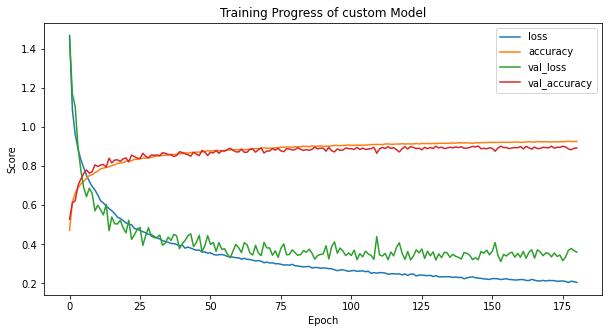

Test-Metrics
-------------------
Test loss = 0.342
Test accuracy = 0.890


In [320]:
plt.figure(figsize=(10,5))
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
pd.DataFrame(hist.history).iloc[:,:4].plot(ax=plt.gca())
plt.title("Training Progress of custom Model")
plt.xlabel("Epoch")
plt.ylabel("Score")
# plt.savefig("./img/training", bbox_inches='tight', facecolor="white", dpi=150)
plt.show()

print('Test-Metrics\n-------------------')
for i in range(len(score)):
      print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

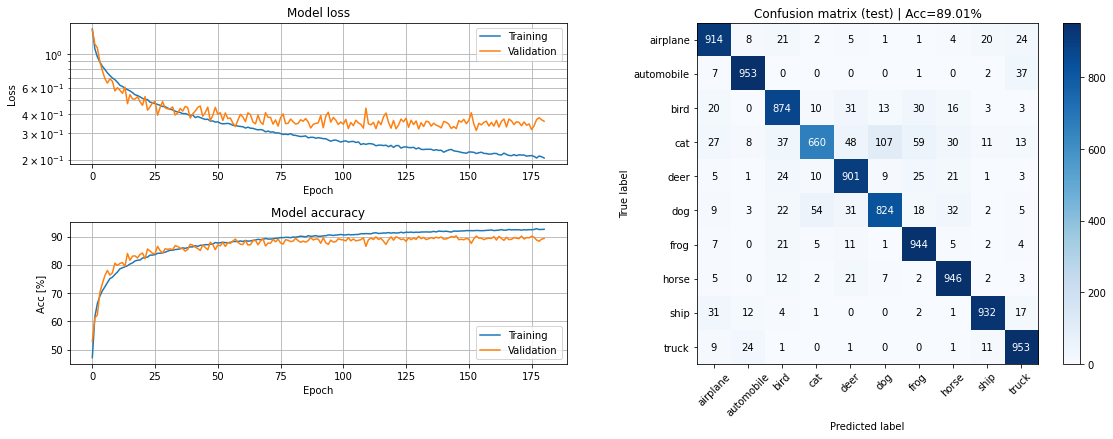

In [125]:
PlotModelEval(model, hist, X_test, y_test, Labels=cifar_labels)

**Now let's look at some concrete cases.**

First we will look at very clear cases, where the model is really confident:

In [ ]:
# Load model 
model = tf.keras.models.load_model('./model/model-best.h5')

In [252]:
# Get class probabilities for all test images
class_probs = mod.predict(X_test)

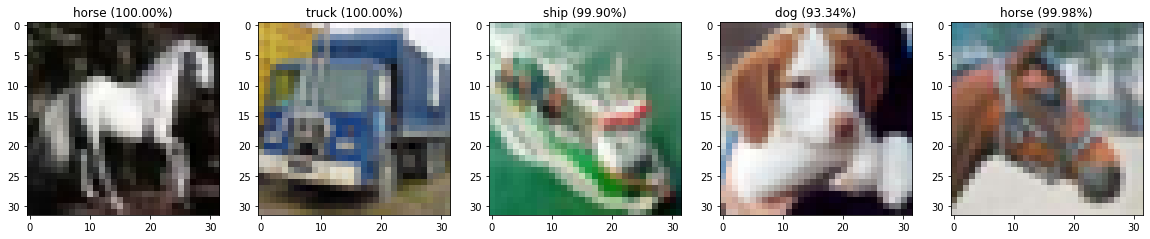

In [321]:
plt.figure(figsize=(20,5))
for i in range(5):
    incr = 13
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[i+incr,])
    most_prob = np.argmax(class_probs[i+incr])
    label = cifar_labels[most_prob]
    prob = class_probs[i+incr,most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")
    
# plt.savefig("./img/classification", bbox_inches='tight', facecolor="white", dpi=150)

Now we take a look at cases where the model is significantly more unsure. As we can see, some of the cases are hard to classify even for humans with bare eye (also because the quality is really bad with 32x32).

In [254]:
unsure_idx = np.where(((class_probs>0.5)&(class_probs<0.6)).sum(axis=1))[0]

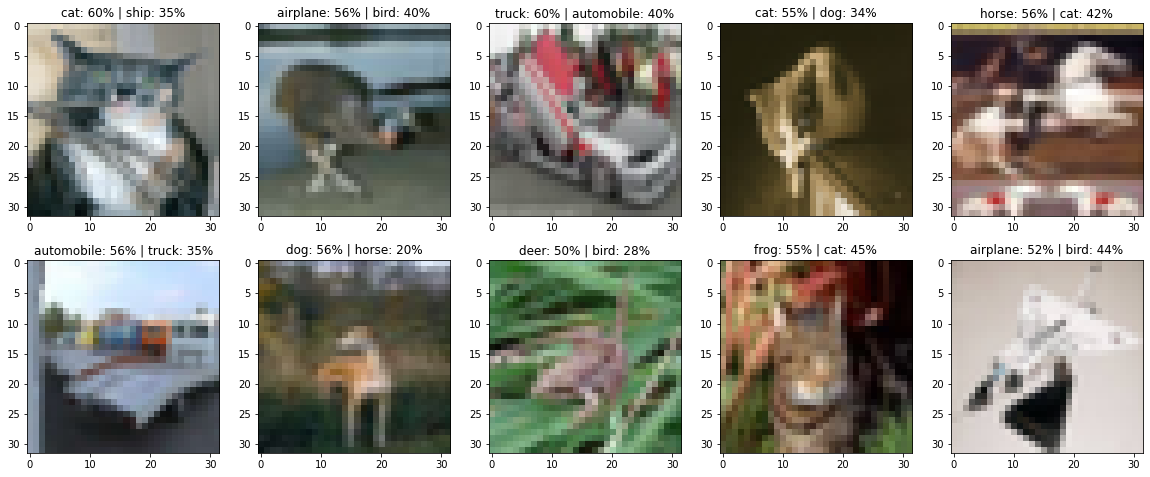

In [288]:
plt.figure(figsize=(20,8))
for i in range(10):
    incr = 240
    idx = unsure_idx[i+incr]
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,])
    most_prob = np.argsort(class_probs[idx])
    label_1, label_2 = cifar_labels[most_prob[-1]], cifar_labels[most_prob[-2]]
    prob_1, prob_2 = class_probs[idx,most_prob[-1]], class_probs[idx,most_prob[-2]]
    plt.title(f"{label_1}: {prob_1*100:.0f}% | {label_2}: {prob_2*100:.0f}%")

 ### Summary
 
The trained model reached a test accuracy of over 89% with a relatively simple model-structure and only minor overfitting due to different regularization techniques like Dropout, EarlyStopping and the use of an ImageGenerator. But there is still a lot of optimization potential especially regarding the architecture of the model (e.g. benchmark is [over 98% with ResNet](https://paperswithcode.com/sota/image-classification-on-cifar-10?tag_filter=3)).